In [ ]:
#%pip install imblearn


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # For handling imbalance in pipeline


In [4]:
# Load data
df = pd.read_csv('brain_cases_flat.csv')


In [5]:
df.head()

,submitter_id,primary_site,disease_type,project_id,diagnosis,icd_10_code,tumor_grade,morphology,age_at_diagnosis_days,gender,race,ethnicity,vital_status,symptoms,other_symptoms,treatments,days_to_last_follow_up,year_of_diagnosis
0,TCGA-HT-A614,Brain,Gliomas,TCGA-LGG,Mixed glioma,C71.0,G2,9382/3,17392.0,male,white,not hispanic or latino,Alive,Headaches,"Headache, Altered Mental Status, Motor / Movem...","Pharmaceutical Therapy, NOS, Antiseizure Treat...",82.0,2013.0
1,TCGA-E1-5311,Brain,Gliomas,TCGA-LGG,"Oligodendroglioma, anaplastic",NaN,NaN,9451/3,13934.0,male,white,not hispanic or latino,Dead,NaN,Headache,"Radiation Therapy, NOS, Pharmaceutical Therapy...",NaN,NaN
2,TCGA-VM-A8CF,Brain,Gliomas,TCGA-LGG,"Astrocytoma, anaplastic",C71.0,G3,9401/3,16334.0,female,white,Unknown,Alive,Motor or Movement Changes,Motor / Movement Change,"Radiation Therapy, NOS, Chemotherapy, Radiatio...",609.0,2013.0
3,TCGA-14-1034,Brain,Gliomas,TCGA-GBM,Glioblastoma,NaN,NaN,9440/3,NaN,female,not reported,not reported,Dead,NaN,NaN,"Pharmaceutical Therapy, NOS, Radiation Therapy...",NaN,NaN
4,TCGA-HT-7677,Brain,Gliomas,TCGA-LGG,"Oligodendroglioma, anaplastic",C71.0,G3,9451/3,19610.0,male,white,not hispanic or latino,Alive,Motor or Movement Changes,"Altered Mental Status, Motor / Movement Change","Radiation Therapy, NOS, Chemotherapy, Antiseiz...",494.0,2009.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   submitter_id            1437 non-null   object 
 1   primary_site            1437 non-null   object 
 2   disease_type            1437 non-null   object 
 3   project_id              1437 non-null   object 
 4   diagnosis               1411 non-null   object 
 5   icd_10_code             857 non-null    object 
 6   tumor_grade             630 non-null    object 
 7   morphology              1411 non-null   object 
 8   age_at_diagnosis_days   1330 non-null   float64
 9   gender                  1420 non-null   object 
 10  race                    1420 non-null   object 
 11  ethnicity               1420 non-null   object 
 12  vital_status            1420 non-null   object 
 13  symptoms                376 non-null    object 
 14  other_symptoms          489 non-null    

In [7]:
df.describe()

,age_at_diagnosis_days,days_to_last_follow_up,year_of_diagnosis
count,1330.000000,1030.000000,982.000000
mean,19395.881203,626.431068,2009.392057
std,5722.309640,715.255842,5.968150
min,445.000000,-9.000000,1989.000000
25%,14863.750000,182.000000,2007.000000
50%,19698.000000,433.500000,2010.000000
75%,23721.250000,804.750000,2013.000000
max,32872.000000,6423.000000,2021.000000


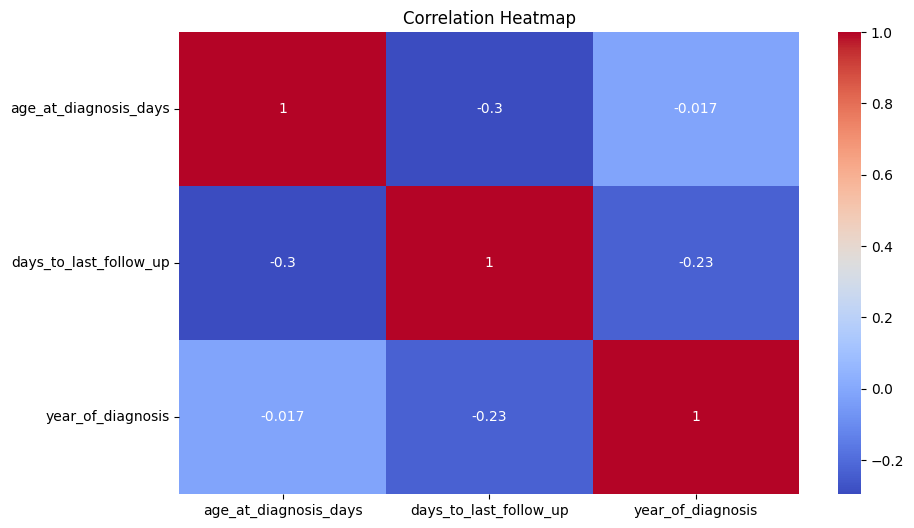

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=['number'])  # only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [9]:
# Preprocess tumor_grade (extract numeric part and drop rows with missing or invalid tumor_grade)
df['tumor_grade'] = df['tumor_grade'].str.extract('(\d+)')
df = df.dropna(subset=['tumor_grade', 'days_to_last_follow_up'])
df['tumor_grade'] = df['tumor_grade'].astype(int)
df['days_to_last_follow_up'] = df['days_to_last_follow_up'].astype(float)

In [10]:
# Fill symptom missing values with empty string
df['symptoms'] = df['symptoms'].fillna('')

# Define features and targets
X = df.drop(columns=['tumor_grade', 'days_to_last_follow_up'])
y_severity = df['tumor_grade']
y_survival = df['days_to_last_follow_up']

In [ ]:
# Define feature groups
categorical_cols = ['gender', 'race', 'ethnicity']
numeric_cols = ['age_at_diagnosis_days']
text_col = 'symptoms'

# Preprocessing pipelines
numeric_transformer = Pipeline([    ('imputer', SimpleImputer(strategy='median')),    ('scaler', StandardScaler())])

categorical_transformer = Pipeline([    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

text_transformer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))

preprocessor = ColumnTransformer([    ('num', numeric_transformer, numeric_cols),    ('cat', categorical_transformer, categorical_cols),    ('text', text_transformer, text_col)], remainder='drop')

# Split data
X_train, X_test, y_sev_train, y_sev_test, y_surv_train, y_surv_test = train_test_split(    X, y_severity, y_survival, test_size=0.2, random_state=42, stratify=y_severity)

# Classification pipeline with imbalance handling (SMOTE)
severity_pipeline = ImbPipeline([    ('pre', preprocessor),    ('smote', SMOTE(random_state=42)),    ('clf', lgb.LGBMClassifier(random_state=42))])

param_dist_clf = {    'clf__num_leaves': [31, 50, 100],    'clf__n_estimators': [100, 200],    'clf__learning_rate': [0.01, 0.05, 0.1]}

search_clf = RandomizedSearchCV(severity_pipeline, param_dist_clf, n_iter=10, cv=StratifiedKFold(n_splits=5), scoring='accuracy', random_state=42, n_jobs=-1)
search_clf.fit(X_train, y_sev_train)

print("Best Severity Model Params:", search_clf.best_params_)

y_sev_pred = search_clf.predict(X_test)
print("=== Severity Model Evaluation ===")
print(f"Accuracy: {accuracy_score(y_sev_test, y_sev_pred):.4f}")
print(classification_report(y_sev_test, y_sev_pred))


[LightGBM] [Info] Number of positive: 173, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 154
[LightGBM] [Info] Number of data points in the train set: 346, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Users\IPG 3\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [12]:

# Regression pipeline
survival_pipeline = Pipeline([
    ('pre', preprocessor),
    ('reg', lgb.LGBMRegressor(random_state=42))
])

param_dist_reg = {
    'reg__num_leaves': [31, 50, 100],
    'reg__n_estimators': [100, 200],
    'reg__learning_rate': [0.01, 0.05, 0.1]
}

search_reg = RandomizedSearchCV(survival_pipeline, param_dist_reg, n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
search_reg.fit(X_train, y_surv_train)

print("Best Survival Model Params:", search_reg.best_params_)

y_surv_pred = search_reg.predict(X_test)
print("=== Survival Model Evaluation ===")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_surv_test, y_surv_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_surv_test, y_surv_pred):.2f}")
print(f"R2 Score: {r2_score(y_surv_test, y_surv_pred):.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 339, number of used features: 18
[LightGBM] [Info] Start training from score 875.182891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\IPG 3\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
